### Gugan Kathiresan
### NUID 002756523

## CS6140- Machine Learning Project
"Analyzing the Contextual Performance of Machine Learning vs Transformers in Toxic Comment Classification"

Approach 2: Transformer (RoBERTa) with FFNN

This code was inspired by 
* Original Code Structure: [Link](https://www.kaggle.com/code/xhlulu/jigsaw-tpu-xlm-roberta)


### Original References
* Original Author: [@xhlulu](https://www.kaggle.com/xhlulu/)
* Original notebook: [Link](https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras)

In [45]:
#Importing all necessary libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import time
import itertools
import matplotlib.pyplot as plt

## Helper Methods

In [2]:
# Method to encode the data using a tokenizer
# params 
# - texts : input data
# - tokenizer : tokenizer of choice
# - maxlen : max length to which the sequence is set to return
def encode_function(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

In [3]:
from keras import backend as K

#Method to calculate recall metric
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

#Method to calculate precision metric
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#Method to calculate f1 metric
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [4]:
# Method to build and compile the model - transformer with FFNN
# params 
# - transformer : transformer model of choice
# - maxlen : max length to which the sequence is set to return
# - number_of_classes : number of classes in the dataset
def build_model(transformer, max_len=512, number_of_classes=2):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    x1 = Dense(256, activation = 'sigmoid')(cls_token)
    out = Dense(number_of_classes, activation='softmax')(x1)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy', recall_m, precision_m, f1_m])
    
    return model

In [44]:
# Method to plot confusion matrix
def plot_confusion_matrix2(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes, fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [6]:
# Method to plot the necessary accuracy and loss graphs from the historical training data
def get_graphs(history_data):
    axes = plt.gca()
    acc = history_data.history['accuracy']
    loss = history_data.history['loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title('Accuracy plot')

    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title('Loss plot')
    plt.legend()
    plt.show()

In [51]:
# Method to get the performance data of the given model.
# This includes the classification report, evaluation results, confusion matrix and PR Curve.
def get_performance(x, y, dataset, model):
#     start_time = time.time()
    test_predictions = model.predict(x)
    rounded_labels=np.argmax(y, axis=1)
    test_predictions2 = np.argmax(test_predictions, axis=1)
    print(classification_report(rounded_labels,test_predictions2))
    target_names = ["NonToxic", "Toxic"]
#     print("Time taken to predict the model " + str(time.time() - start_time))
    
    print("---------------------------------------------------------")
    print("CONFUSION MATRIX")
    plot_confusion_matrix2(y_true = rounded_labels, y_pred = test_predictions2, classes=target_names)
    
    print("---------------------------------------------------------")
    print("PRECISION RECALL CURVE")
    precision = dict()
    recall = dict()
    for i in range(2):
        precision[i], recall[i], _ = precision_recall_curve(y[:,i],
                                                            test_predictions[:, i])
        if (i==0):
          plt.plot(recall[i], precision[i], lw=2, label='NonToxic')
        elif (i==1):
          plt.plot(recall[i], precision[i], lw=2, label='Toxic')
    
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")
    plt.show()

### Setting Up Experiments

In [8]:
# Check if the TPU is available and distribute resources accordingly.
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [9]:
#Setting initial Hyperparameters

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 275
MODEL = 'jplu/tf-xlm-roberta-base'
id2label = {0: "NONTOXIC", 1: "TOXIC"}
label2id = {"NONTOXIC": 0, "TOXIC": 1}
classes_number = 2

### Dataset Processing

In [10]:
# Creating the tokenizer for the model of choice
tokenizer = AutoTokenizer.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

## Load text data into memory

In [63]:
#Importing the data

train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")
train2.toxic = train2.toxic.round().astype(int)
valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')

In [64]:
# Combine train1 with a subset of train2
train = pd.concat([
    train1[['comment_text', 'toxic']],
    train2[['comment_text', 'toxic']].query('toxic==1'),
    train2[['comment_text', 'toxic']].query('toxic==0').sample(n=100000, random_state=0)
])

In [65]:
#Preprocessing

train = train.groupby('toxic').apply(
    lambda x: x.sample(frac=0.35)
)
train = train.droplevel(0)

nontoxic = train[train['toxic']==0]
toxic = train[train["toxic"]==1]
new_nontoxic = nontoxic.sample(toxic.shape[0])
train = shuffle(pd.concat([toxic, new_nontoxic]))

In [66]:
#Deleting to manage resources

del train1
del train2

In [67]:
#Designating the train and validation variables using the tokenizer encoded data

x_train = encode_function(train.comment_text.values.tolist(), tokenizer, maxlen=MAX_LEN)
x_valid = encode_function(valid.comment_text.values.tolist(), tokenizer, maxlen=MAX_LEN)

y_train = train.toxic.values.tolist()
y_valid = valid.toxic.values.tolist()

#One Hot Encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes = 2)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes = 2)

#Assigning the number of steps per epoch for model execution
n_steps = x_train.shape[0] // BATCH_SIZE
n_steps_valid = x_valid.shape[0] // BATCH_SIZE

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [68]:
# Preparing the dataset loaders

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)


In [69]:
del train
del valid
del x_train
del y_train

### Loading the Model

In [18]:
%%time
with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL, num_labels=classes_number, id2label=id2label, label2id=label2id)
    
    model = build_model(transformer_layer, max_len=MAX_LEN, number_of_classes=classes_number)
model.summary()

Downloading:   0%|          | 0.00/1.76G [00:00<?, ?B/s]

Some layers from the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 275)]             0         
_________________________________________________________________
tfxlm_roberta_model (TFXLMRo TFBaseModelOutputWithPool 278043648 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               196864    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 278,241,026
Trainable params: 278,241,026
Non-trainable params: 0
_________________________________________________________________
CPU times: user 39.3 s, sys: 5.68 s, total: 45 s
Wall time: 1min


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Training and Evaluating Results

In [19]:
# Training data is predominantly English
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=2
)

Epoch 1/2
5845/5845 [==============================] - 3558s 606ms/step - loss: 0.5483 - accuracy: 0.6717 - recall_m: 0.6717 - precision_m: 0.6717 - f1_m: 0.6717 - val_loss: 1.1590 - val_accuracy: 0.2941 - val_recall_m: 0.2941 - val_precision_m: 0.2941 - val_f1_m: 0.2941
Epoch 2/2
5845/5845 [==============================] - 3543s 606ms/step - loss: 0.2950 - accuracy: 0.8747 - recall_m: 0.8747 - precision_m: 0.8747 - f1_m: 0.8747 - val_loss: 1.2635 - val_accuracy: 0.2180 - val_recall_m: 0.2180 - val_precision_m: 0.2180 - val_f1_m: 0.2180


In [70]:
# Validation data is multilingual
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps_valid,
    epochs=5
)

Epoch 1/5
500/500 [==============================] - 295s 590ms/step - loss: 0.1554 - accuracy: 0.9323 - recall_m: 0.9323 - precision_m: 0.9323 - f1_m: 0.9323
Epoch 2/5
500/500 [==============================] - 295s 590ms/step - loss: 0.1310 - accuracy: 0.9439 - recall_m: 0.9439 - precision_m: 0.9439 - f1_m: 0.9439
Epoch 3/5
500/500 [==============================] - 295s 591ms/step - loss: 0.1079 - accuracy: 0.9576 - recall_m: 0.9576 - precision_m: 0.9576 - f1_m: 0.9576
Epoch 4/5
500/500 [==============================] - 295s 590ms/step - loss: 0.0914 - accuracy: 0.9639 - recall_m: 0.9639 - precision_m: 0.9639 - f1_m: 0.9639
Epoch 5/5
500/500 [==============================] - 295s 590ms/step - loss: 0.0771 - accuracy: 0.9700 - recall_m: 0.9700 - precision_m: 0.9700 - f1_m: 0.9700


In [71]:
print("---------------------------------------------------------")
print("EVALUATING")
model.evaluate(valid_dataset)

---------------------------------------------------------
EVALUATING
500/500 [==============================] - 98s 195ms/step - loss: 0.5667 - accuracy: 0.6374 - recall_m: 0.6374 - precision_m: 0.6374 - f1_m: 0.6374


[0.5667135119438171,
 0.637374997138977,
 0.637374997138977,
 0.637374997138977,
 0.6373749375343323]

---------------------------------------------------------
VALIDATION PERFORMANCE
              precision    recall  f1-score   support

           0       0.95      0.60      0.74      6770
           1       0.27      0.82      0.41      1230

    accuracy                           0.64      8000
   macro avg       0.61      0.71      0.57      8000
weighted avg       0.84      0.64      0.69      8000

---------------------------------------------------------
CONFUSION MATRIX


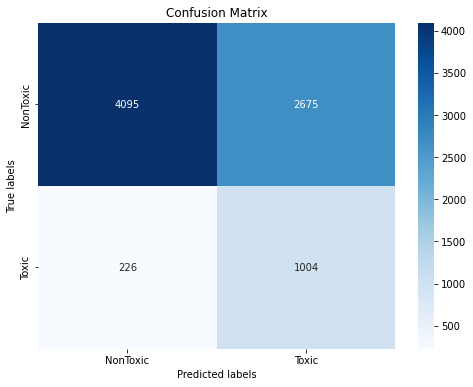

---------------------------------------------------------
PRECISION RECALL CURVE


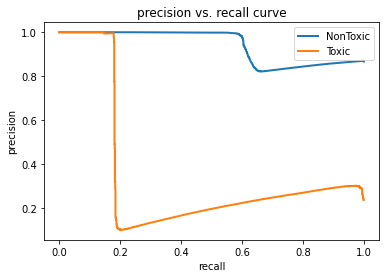

---------------------------------------------------------
TRAIN LOSS & ACCURACY CURVES


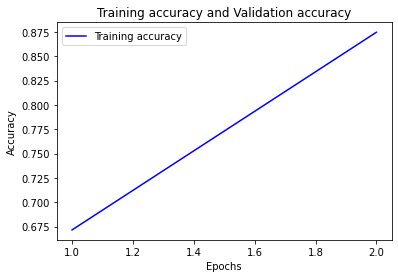

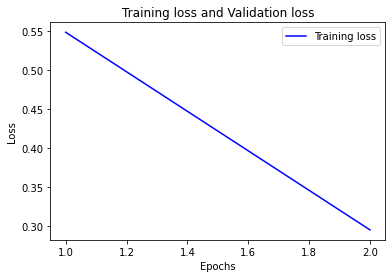

---------------------------------------------------------
VALIDATION LOSS & ACCURACY CURVES


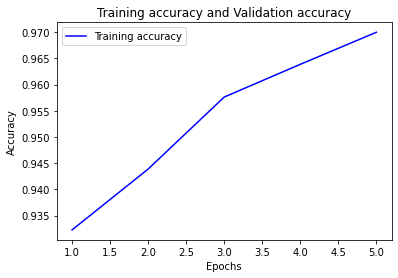

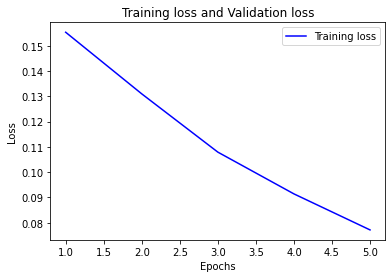

In [72]:
#Validation and Training set performance results
print("---------------------------------------------------------")
print("VALIDATION PERFORMANCE")
get_performance(x_valid, y_valid, valid_dataset, model)
print("---------------------------------------------------------")
print("TRAIN LOSS & ACCURACY CURVES")
get_graphs(train_history)
print("---------------------------------------------------------")
print("VALIDATION LOSS & ACCURACY CURVES")
get_graphs(train_history_2)

In [73]:
del train_dataset
del valid_dataset

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


---------------------------------------------------------
EVALUATING
3989/3989 [==============================] - 779s 195ms/step - loss: 0.8487 - accuracy: 0.5819 - recall_m: 0.5819 - precision_m: 0.5819 - f1_m: 0.5819
              precision    recall  f1-score   support

           0       0.87      0.54      0.67     49402
           1       0.31      0.72      0.44     14410

    accuracy                           0.58     63812
   macro avg       0.59      0.63      0.55     63812
weighted avg       0.74      0.58      0.62     63812

---------------------------------------------------------
CONFUSION MATRIX


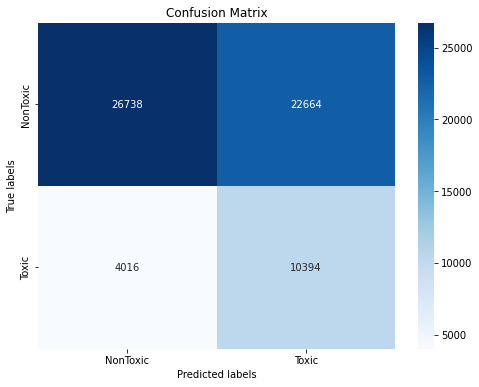

---------------------------------------------------------
PRECISION RECALL CURVE


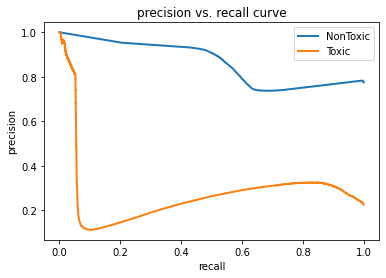

In [74]:
# Loading testing dataset and visualizing performance
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
test_labels = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test_labels.csv')

x_test = encode_function(test.content.values.tolist(), tokenizer, maxlen=MAX_LEN)
y_test = test_labels.toxic.values.tolist()
y_test = tf.keras.utils.to_categorical(y_test, num_classes = 2)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_test, y_test))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

print("---------------------------------------------------------")
print("EVALUATING")
model.evaluate(test_dataset)

get_performance(x_test, y_test, test_dataset, model)